In [ ]:
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

data = data[:, 1:]

# normalize the data
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor(dataNorm).float()

In [ ]:
def createTheMNISTAE(enc_units, bottleneck_units):

    class aenet(nn.Module):

        def __init__(self):

            super().__init__()

            # input layer
            self.input = nn.Linear(784, enc_units)

            # encoder layer
            self.enc = nn.Linear(enc_units, bottleneck_units)

            # latent layer
            self.lat = nn.Linear(bottleneck_units, enc_units)

            # decoder layer
            self.dec = nn.Linear(enc_units, 784)

        def forward(self, X):
            X = F.relu(self.input(X))
            X = F.relu(self.enc(X))
            X = F.relu(self.lat(X))

            return torch.sigmoid(self.dec(X))

    net = aenet()

    lossfun = nn.MSELoss()

    optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

    return net, lossfun, optimizer

In [ ]:
net, lossfun, optimizer = createTheMNISTAE(250, 50)

X = dataT[:5, :]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


In [ ]:
def function2trainTheModel(enc_units, bottleneck_units):

    numepochs = 3

    net, lossfun, optimizer = createTheMNISTAE(enc_units, bottleneck_units)

    losses = np.zeros(numepochs)

    # batch size and number of batches
    batchsize = 32
    numBatches = int(dataT.shape[0]/batchsize)

    for epochi in range(numepochs):

        randidx = np.random.permutation(dataT.shape[0]).astype(int)
        batchLoss = []
        for batch in range(numBatches):
            samp2use = range((batch - 1)*batchsize, batch*batchsize)
            X = dataT[randidx[samp2use], :]

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, X)

            # back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

        # losses in this epoch
        losses[epochi] = np.mean(batchLoss)


    return losses, net


In [ ]:
enc_units = np.linspace(10, 500, 12).astype(int)
bottleneck_units = np.linspace(5, 100, 8).astype(int)
total_losses = np.zeros((12,8))

for i, enc in enumerate(enc_units):
    for j, bottleneck in enumerate(bottleneck_units):

        losses = function2trainTheModel(enc, bottleneck)[0]
        total_losses[i, j] = np.mean(losses[-3:])

        # send pdate message
        currentIter = i * len(bottleneck_units) + j + 1
        totalIters = 12*8
        msg = 'Finished Experiment {}/{}'. format(currentIter, totalIters)
        sys.stdout.write('\r' + msg)


Finished Experiment 96/96

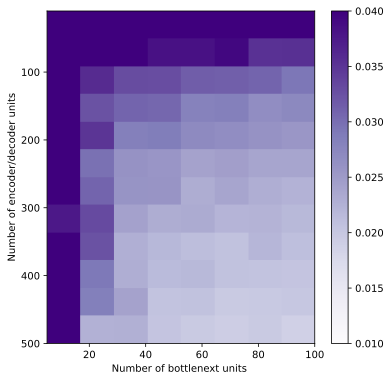

In [ ]:
fig = plt.figure(figsize = (6, 6))

plt.imshow(total_losses, aspect = 'auto',
           vmin = .01, vmax = .04, cmap = 'Purples',
           extent = [bottleneck_units[0], bottleneck_units[-1], enc_units[-1], enc_units[0]])
plt.xlabel('Number of bottlenext units ')
plt.ylabel('Number of encoder/decoder units')
plt.colorbar()
plt.show()

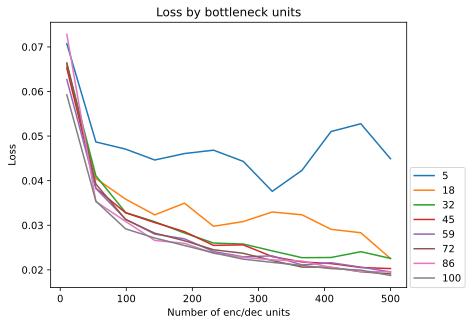

In [ ]:
# perhaps a line plot will better reveal the sudden transition

plt.plot(enc_units,total_losses)
plt.legend(bottleneck_units,loc=(1.01,0))
plt.xlabel('Number of enc/dec units')
plt.title('Loss by bottleneck units')
plt.ylabel('Loss')
plt.show()